# Lab 3 - Speech Processing
#### Sanjushree Rajan
#### BL.EN.U4AIE23130

---

## Objective 1

To identify, segment, and visualize different phoneme classes in a recorded speech signal and to analyze voiced and unvoiced regions using waveform-level inspection.

**Sentence:** *"She judged the blue pen, put it on the table, and quietly whispered yes."*

## 1. Library Imports

In [1]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

import warnings
warnings.filterwarnings("ignore")

/home/sanju/Documents/Sem6/SP/lab/Lab 3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Pre-trained Wav2Vec2 Model

In [2]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()
print("Model loaded successfully.")

Loading weights: 100%|██████████| 212/212 [00:00<00:00, 219.21it/s, Materializing param=wav2vec2.feature_projection.projection.weight]                         
Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded successfully.


## 3. Load and Preprocess Speech Signal (Objective 1)

Load `sentence1.wav` — *"She judged the blue pen, put it on the table, and quietly whispered yes."*

In [3]:
TARGET_SR = 16000
audio_filename = "sentence1.wav"

if not os.path.exists(audio_filename):
    raise FileNotFoundError(
        f"'{audio_filename}' not found. Please upload your recorded audio file."
    )

# Load as mono, resample to 16 kHz
waveform_np, sample_rate = librosa.load(audio_filename, sr=TARGET_SR, mono=True)

# Normalize
waveform_np = waveform_np / (np.max(np.abs(waveform_np)) + 1e-9)

# Convert to torch tensor shape [1, N]
waveform = torch.from_numpy(waveform_np).float().unsqueeze(0)

print(f"Loaded '{audio_filename}'")
print(f"Sample rate : {sample_rate} Hz")
print(f"Duration    : {waveform.shape[1] / sample_rate:.2f} s")
print(f"Samples     : {waveform.shape[1]}")

Loaded 'sentence1.wav'
Sample rate : 16000 Hz
Duration    : 6.89 s
Samples     : 110251


## 4. Plot Original Speech Waveform

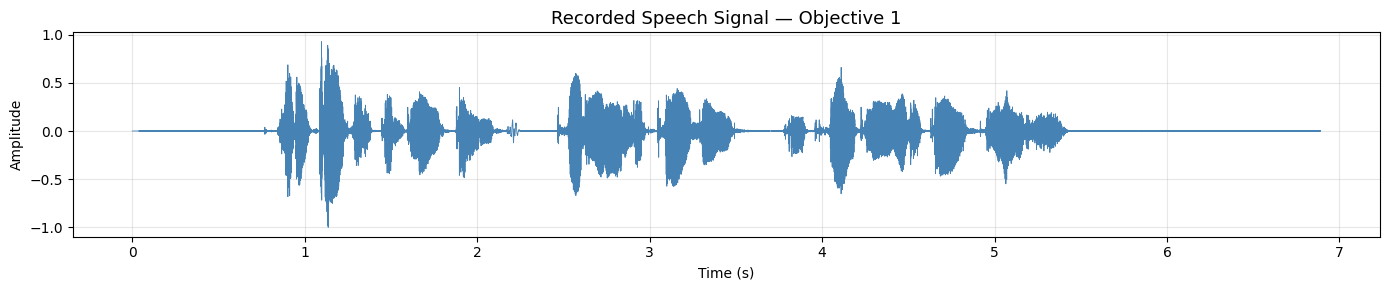

In [4]:
time_axis = np.arange(waveform.shape[1]) / sample_rate

plt.figure(figsize=(14, 3))
plt.plot(time_axis, waveform[0].numpy(), color='steelblue', linewidth=0.6)
plt.title("Recorded Speech Signal — Objective 1", fontsize=13)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Phoneme Recognition via Wav2Vec2

In [5]:
input_values = processor(
    waveform_np,
    sampling_rate=TARGET_SR,
    return_tensors="pt"
).input_values

with torch.no_grad():
    logits1 = model(input_values).logits

predicted_ids1 = torch.argmax(logits1, dim=-1)
transcription1 = processor.decode(predicted_ids1[0])

print("Recognized Phoneme / Character Sequence:")
print(transcription1)

Recognized Phoneme / Character Sequence:
SHE JUDGED THE BLUE PEN PUT IT ON THE TABLE AND QUIETLY WHISPERED YES


## 6. Estimate Phoneme Time Intervals

Each model output frame covers `waveform_length / num_frames` audio samples.  
We walk through the predicted token sequence and group consecutive identical tokens into intervals.

In [6]:
def get_phoneme_intervals(predicted_ids, logits, waveform, sr, proc):
    """Convert frame-level token predictions to phoneme time intervals."""
    tokens = predicted_ids[0].numpy()
    # seconds per model output frame
    time_per_frame = waveform.shape[1] / logits.shape[1] / sr

    intervals = []
    current_phoneme = None
    start_idx = 0

    for idx, token_id in enumerate(tokens):
        phoneme = proc.decode([token_id]).strip()

        if phoneme and phoneme != current_phoneme:
            if current_phoneme is not None:
                intervals.append({
                    "phoneme"     : current_phoneme,
                    "start_sample": int(start_idx * time_per_frame * sr),
                    "end_sample"  : int(idx       * time_per_frame * sr)
                })
            current_phoneme = phoneme
            start_idx = idx

    # flush last segment
    if current_phoneme is not None:
        intervals.append({
            "phoneme"     : current_phoneme,
            "start_sample": int(start_idx * time_per_frame * sr),
            "end_sample"  : waveform.shape[1]
        })

    return intervals


phoneme_intervals1 = get_phoneme_intervals(
    predicted_ids1, logits1, waveform, sample_rate, processor
)

print(f"Detected {len(phoneme_intervals1)} phoneme segments:")
for p in phoneme_intervals1:
    print(f"  {p['phoneme']:>4s}  "
          f"{p['start_sample']/sample_rate:.3f}s – "
          f"{p['end_sample']/sample_rate:.3f}s")

Detected 56 phoneme segments:
     S  0.881s – 0.921s
     H  0.921s – 0.961s
     E  0.961s – 1.082s
     J  1.082s – 1.162s
     U  1.162s – 1.182s
     D  1.182s – 1.262s
     G  1.262s – 1.302s
     E  1.302s – 1.322s
     D  1.322s – 1.462s
     T  1.462s – 1.482s
     H  1.482s – 1.522s
     E  1.522s – 1.582s
     B  1.582s – 1.623s
     L  1.623s – 1.743s
     U  1.743s – 1.763s
     E  1.763s – 1.863s
     P  1.863s – 1.943s
     E  1.943s – 2.003s
     N  2.003s – 2.464s
     P  2.464s – 2.544s
     U  2.544s – 2.604s
     T  2.604s – 2.704s
     I  2.704s – 2.724s
     T  2.724s – 2.824s
     O  2.824s – 2.844s
     N  2.844s – 2.925s
     T  2.925s – 2.945s
     H  2.945s – 2.965s
     E  2.965s – 3.045s
     T  3.045s – 3.165s
     A  3.165s – 3.265s
     B  3.265s – 3.325s
     L  3.325s – 3.385s
     E  3.385s – 3.806s
     A  3.806s – 3.826s
     N  3.826s – 3.866s
     D  3.866s – 3.986s
     Q  3.986s – 4.006s
     U  4.006s – 4.106s
     I  4.106s – 4.166s
     E  4.

## 7. Phoneme Category Classification

Wav2Vec2-base-960h outputs uppercase English characters (A-Z).  
We map every character to one of the standard phoneme categories.

In [7]:
# Comprehensive character-to-category map for Wav2Vec2 letter output
phoneme_categories = {
    # Vowels
    'A': 'vowel',      # /æ/, /eɪ/, /ɑ/
    'E': 'vowel',      # /ɛ/, /iː/
    'I': 'vowel',      # /ɪ/, /aɪ/
    'O': 'vowel',      # /ɒ/, /oʊ/
    'U': 'vowel',      # /ʌ/, /uː/

    # Plosives (stops)
    'P': 'plosive',    # /p/
    'B': 'plosive',    # /b/
    'T': 'plosive',    # /t/
    'D': 'plosive',    # /d/
    'K': 'plosive',    # /k/
    'G': 'plosive',    # /g/

    # Fricatives
    'F': 'fricative',  # /f/
    'V': 'fricative',  # /v/
    'S': 'fricative',  # /s/
    'Z': 'fricative',  # /z/
    'H': 'fricative',  # /h/

    # Affricates — represented by 'J' (DJH sound) and 'C' (CH sound)
    'J': 'affricate',  # /dʒ/ (judge)
    'C': 'affricate',  # /tʃ/ (chair)

    # Semivowels / approximants
    'W': 'semivowel',  # /w/
    'Y': 'semivowel',  # /j/
    'L': 'semivowel',  # /l/
    'R': 'semivowel',  # /r/

    # Nasals
    'M': 'nasal',      # /m/
    'N': 'nasal',      # /n/

    # Remaining consonants — treat as whisper/other
    'Q': 'whisper/other',
    'X': 'whisper/other',
}

# Voicing map — used for voiced vs unvoiced selection
voiced_categories   = {'vowel', 'semivowel', 'nasal', 'affricate'}
unvoiced_categories = {'fricative', 'plosive', 'whisper/other'}

for p in phoneme_intervals1:
    p["category"] = phoneme_categories.get(p["phoneme"].upper(), "whisper/other")

print("Category assignments:")
for p in phoneme_intervals1:
    print(f"  {p['phoneme']:>4s}  →  {p['category']}")

Category assignments:
     S  →  fricative
     H  →  fricative
     E  →  vowel
     J  →  affricate
     U  →  vowel
     D  →  plosive
     G  →  plosive
     E  →  vowel
     D  →  plosive
     T  →  plosive
     H  →  fricative
     E  →  vowel
     B  →  plosive
     L  →  semivowel
     U  →  vowel
     E  →  vowel
     P  →  plosive
     E  →  vowel
     N  →  nasal
     P  →  plosive
     U  →  vowel
     T  →  plosive
     I  →  vowel
     T  →  plosive
     O  →  vowel
     N  →  nasal
     T  →  plosive
     H  →  fricative
     E  →  vowel
     T  →  plosive
     A  →  vowel
     B  →  plosive
     L  →  semivowel
     E  →  vowel
     A  →  vowel
     N  →  nasal
     D  →  plosive
     Q  →  whisper/other
     U  →  vowel
     I  →  vowel
     E  →  vowel
     T  →  plosive
     L  →  semivowel
     Y  →  semivowel
     W  →  semivowel
     H  →  fricative
     I  →  vowel
     S  →  fricative
     P  →  plosive
     E  →  vowel
     R  →  semivowel
     E  →  vowel
    

## 8. Extract and Plot Each Phoneme Waveform

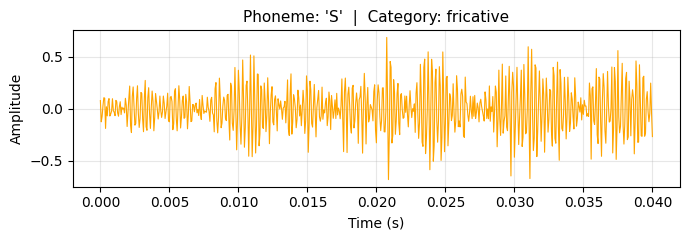

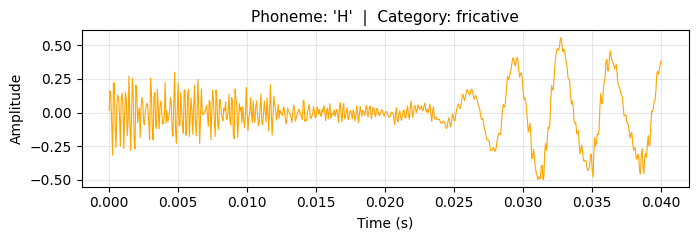

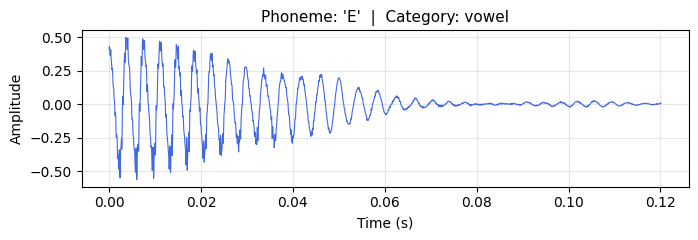

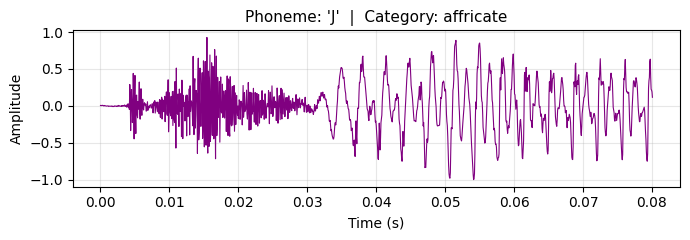

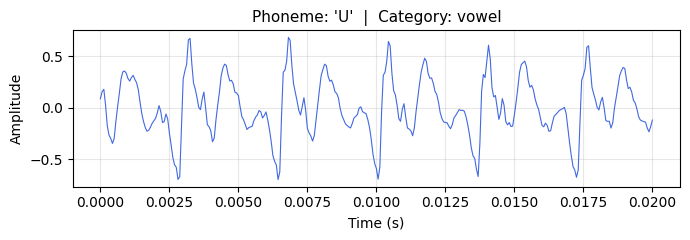

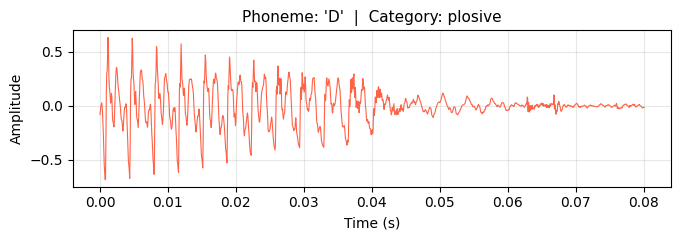

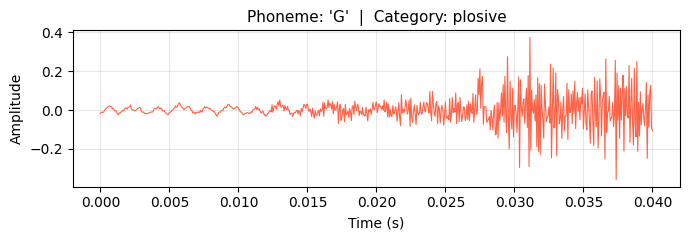

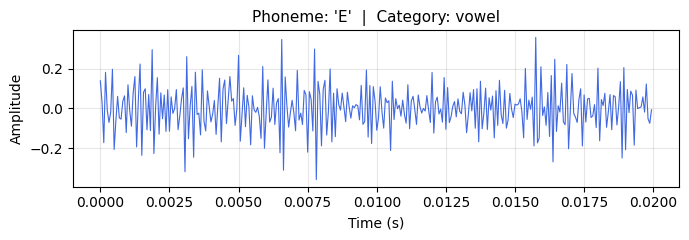

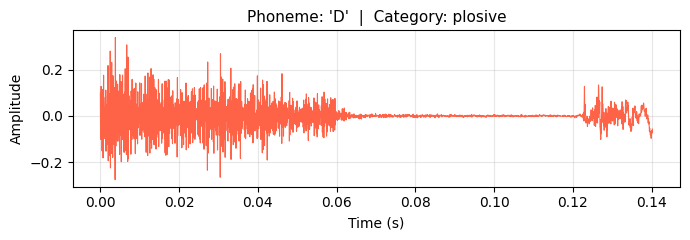

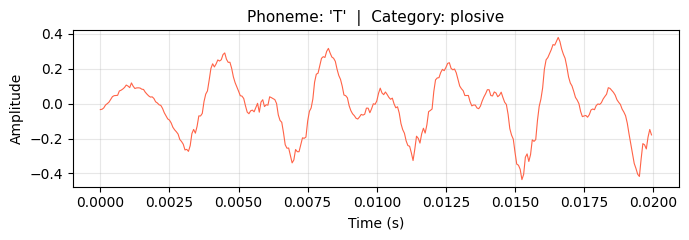

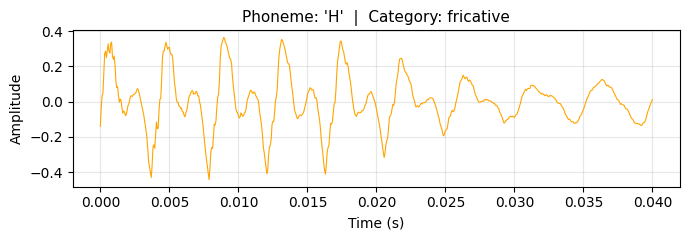

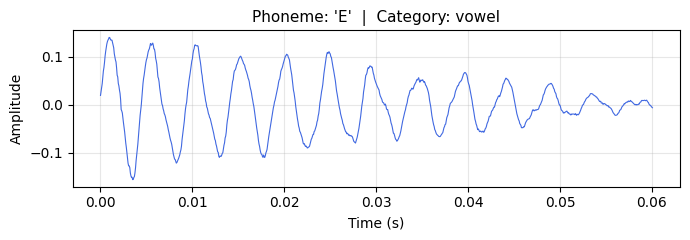

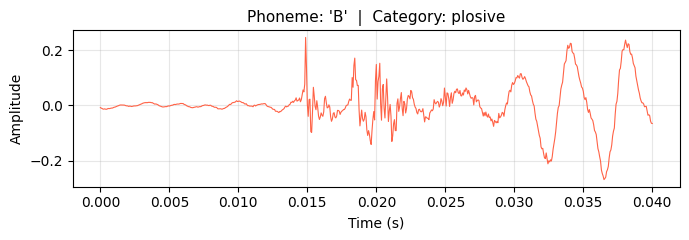

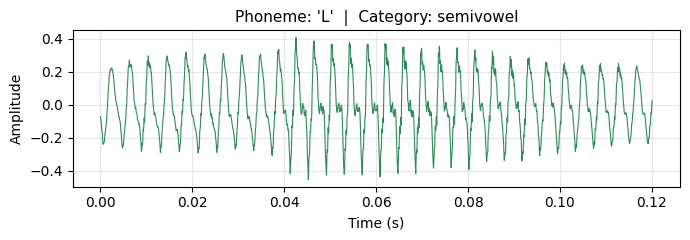

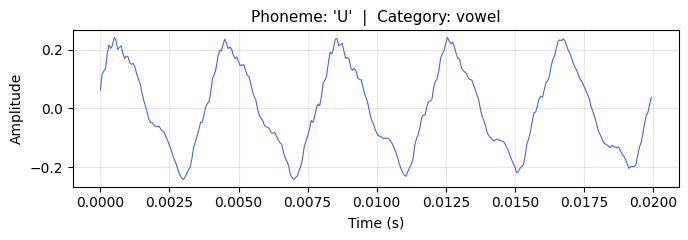

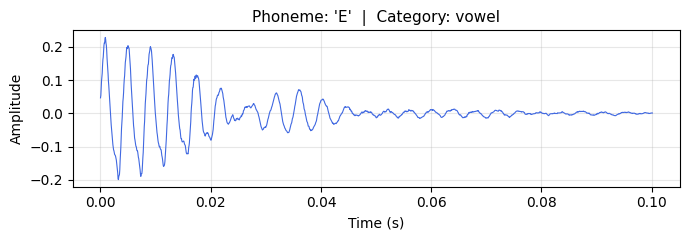

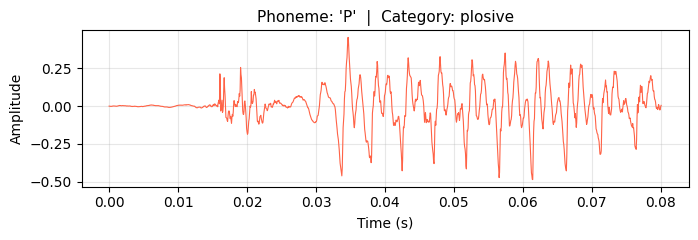

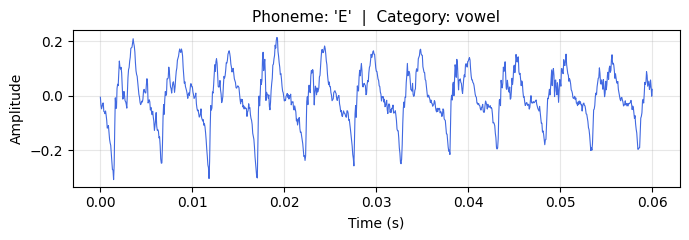

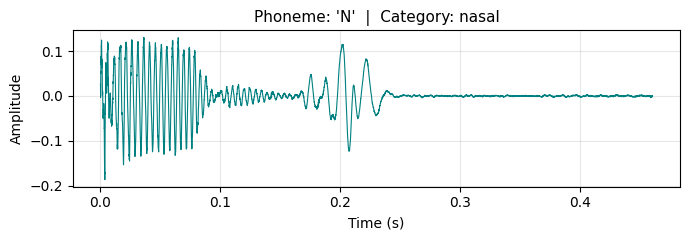

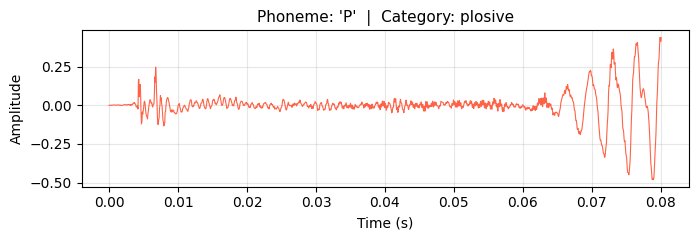

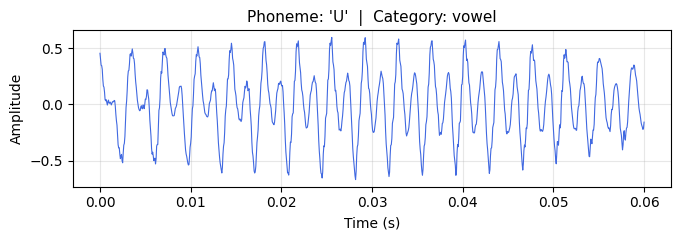

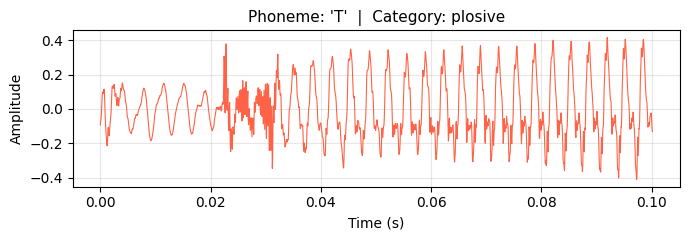

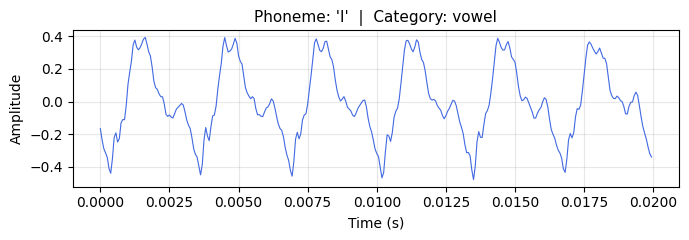

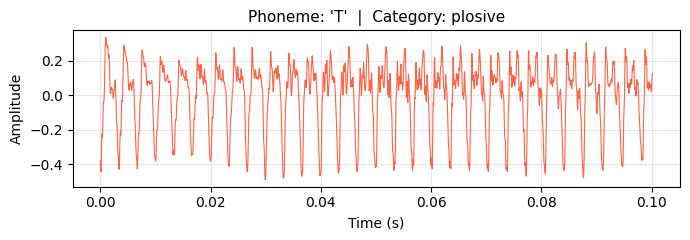

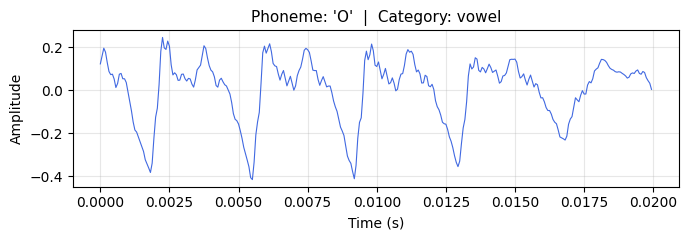

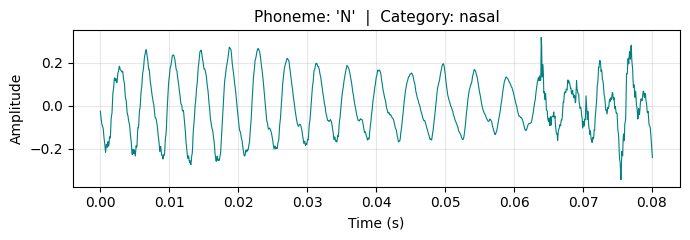

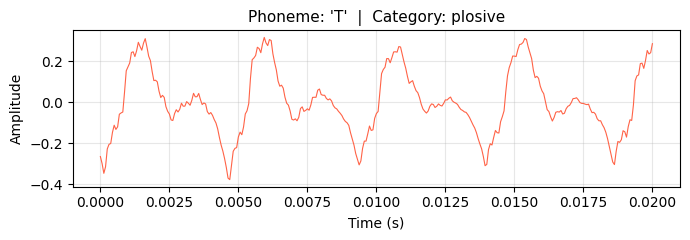

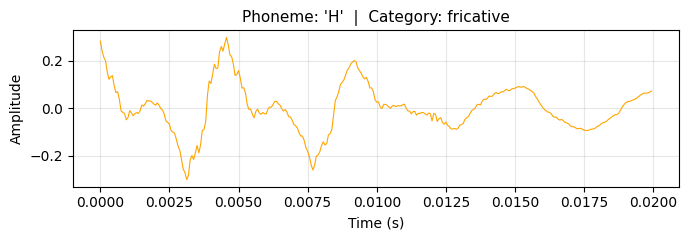

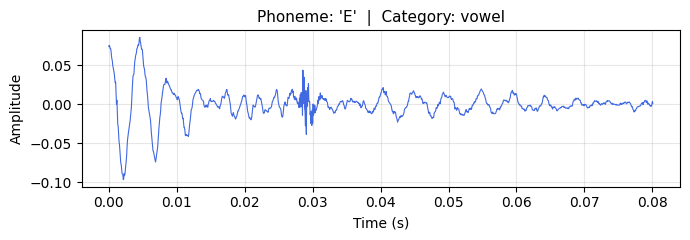

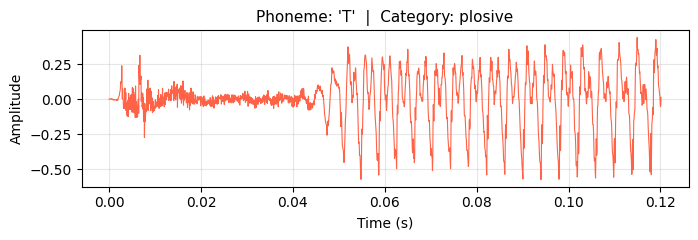

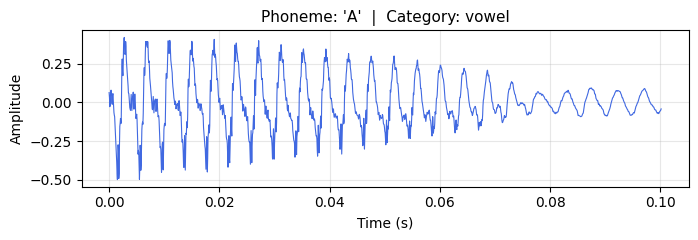

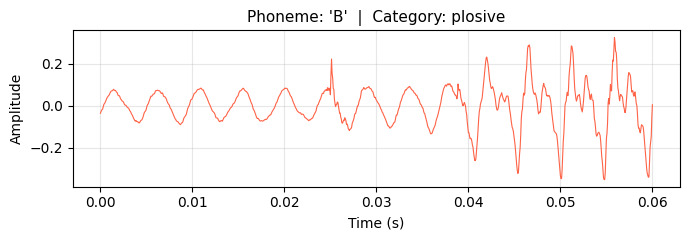

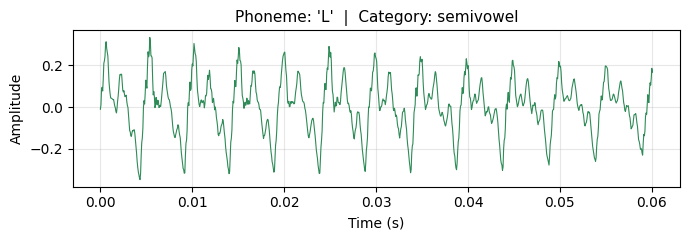

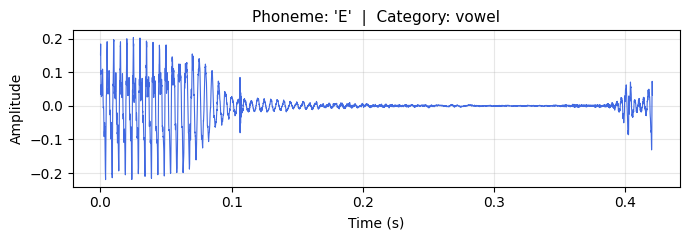

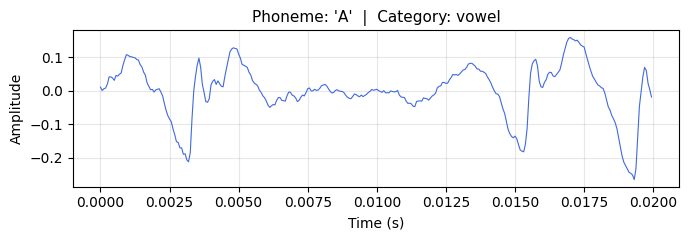

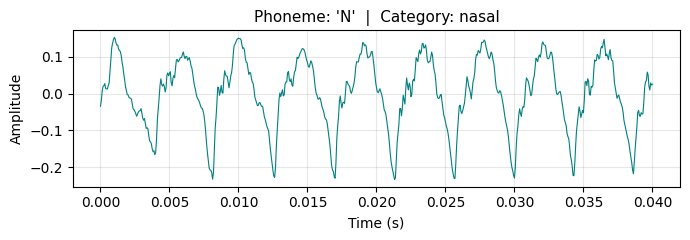

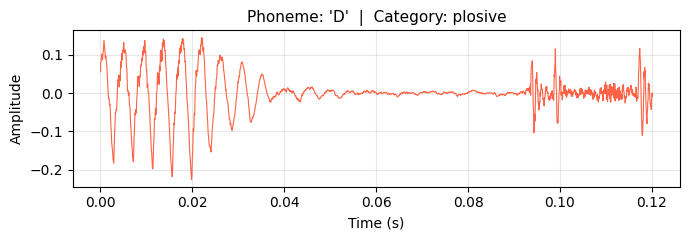

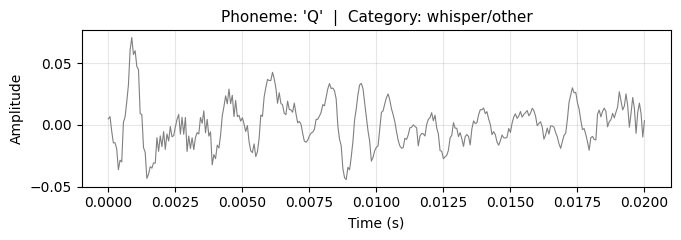

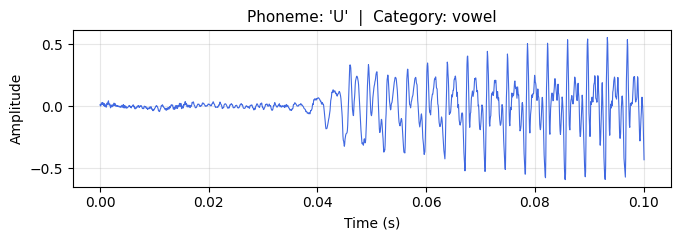

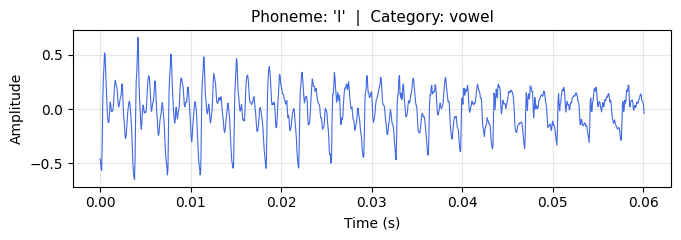

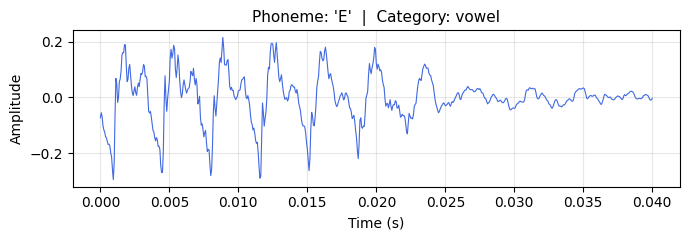

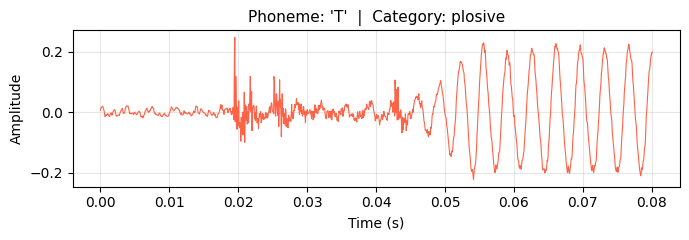

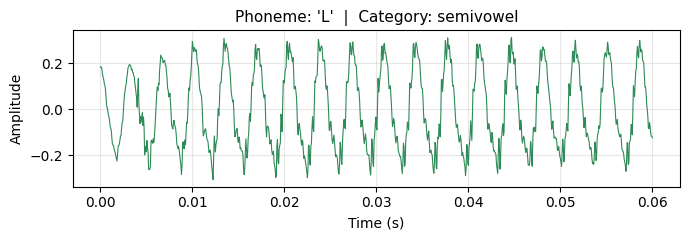

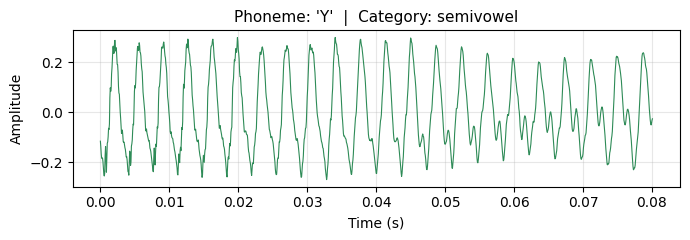

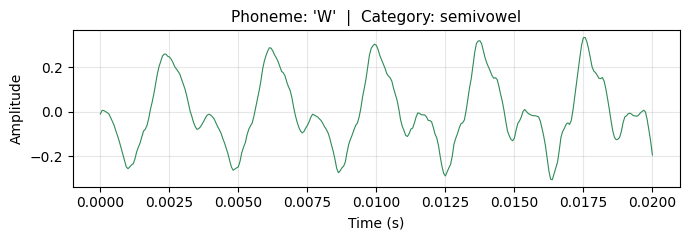

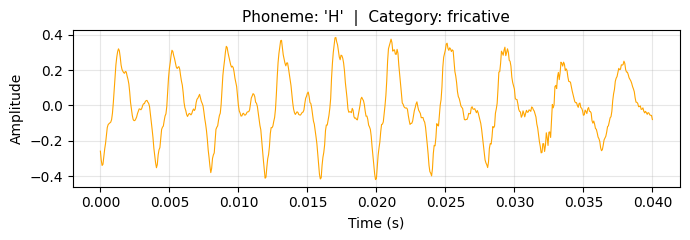

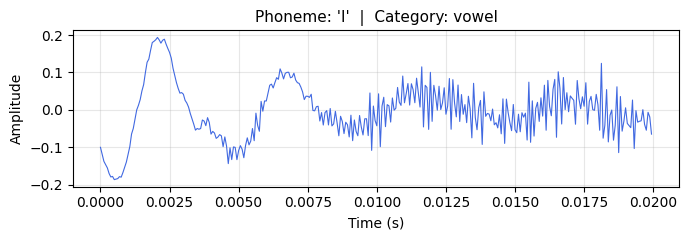

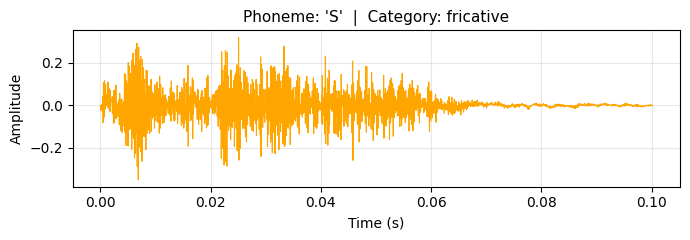

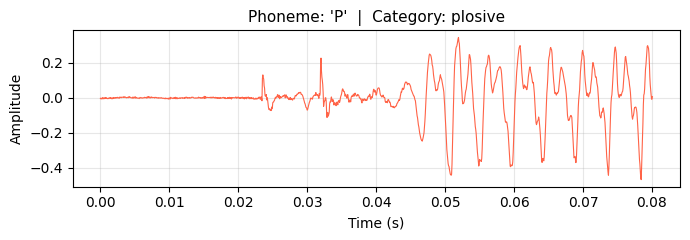

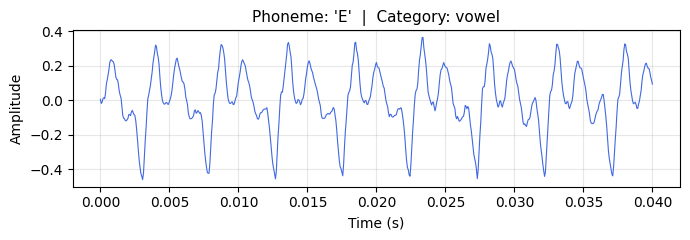

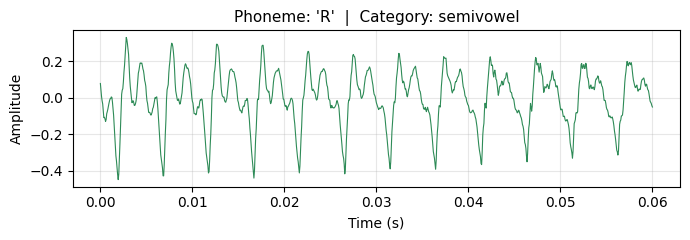

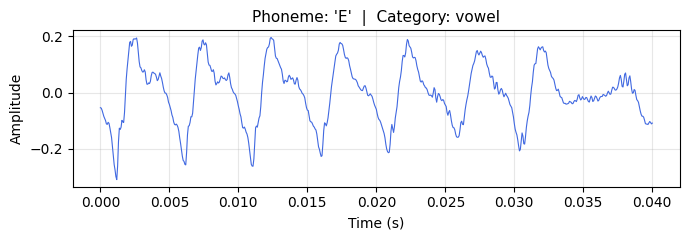

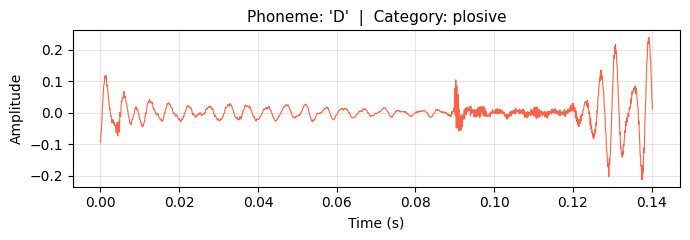

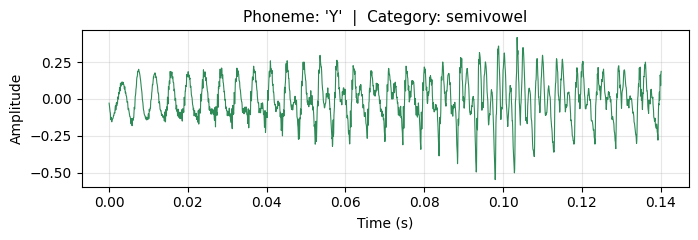

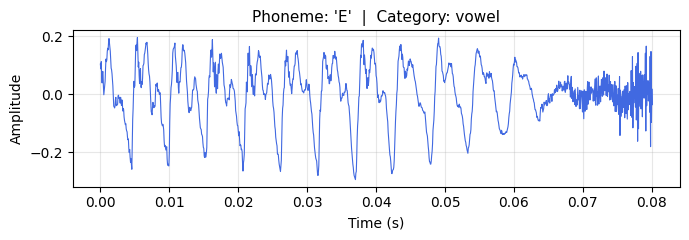

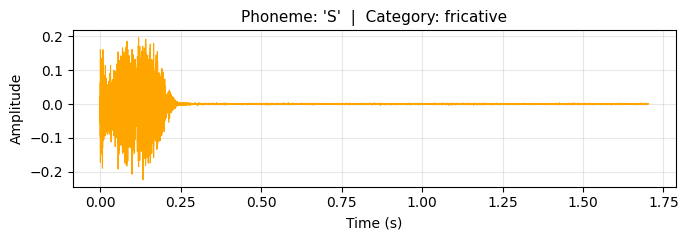

In [8]:
def plot_phoneme(segment, sr, phoneme, category, color='steelblue'):
    """Plot a single phoneme segment waveform."""
    if len(segment) == 0:
        print(f"  Skipping '{phoneme}' — empty segment.")
        return
    t = np.arange(len(segment)) / sr
    plt.figure(figsize=(7, 2.5))
    plt.plot(t, segment, color=color, linewidth=0.8)
    plt.title(f"Phoneme: '{phoneme}'  |  Category: {category}", fontsize=11)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


category_colors = {
    'vowel'       : 'royalblue',
    'plosive'     : 'tomato',
    'fricative'   : 'orange',
    'affricate'   : 'purple',
    'semivowel'   : 'seagreen',
    'nasal'       : 'teal',
    'whisper/other': 'gray',
}

for p in phoneme_intervals1:
    segment = waveform[0, p["start_sample"]:p["end_sample"]].numpy()
    color = category_colors.get(p["category"], 'steelblue')
    plot_phoneme(segment, sample_rate, p["phoneme"], p["category"], color=color)

## 9. Voiced vs Unvoiced Segment Comparison

Select one voiced phoneme (vowel / semivowel) and one unvoiced phoneme (fricative / plosive) and compare their waveform characteristics.

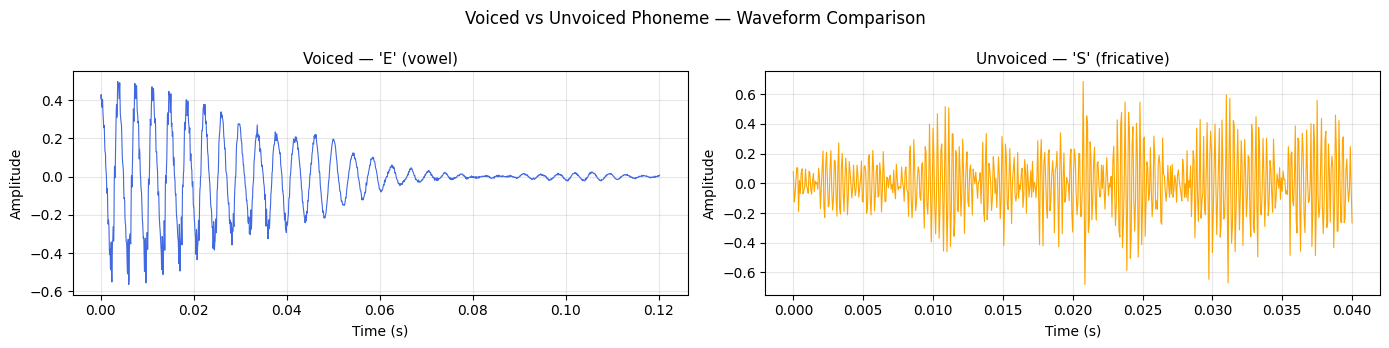


Voiced  : 'E'  (0.961s – 1.082s)
Unvoiced: 'S'  (0.881s – 0.921s)


In [9]:
# Select representative voiced and unvoiced segments
voiced_seg   = next(
    (p for p in phoneme_intervals1
     if p["category"] in voiced_categories
     and (p["end_sample"] - p["start_sample"]) > 400),   # at least 25 ms at 16 kHz
    None
)
unvoiced_seg = next(
    (p for p in phoneme_intervals1
     if p["category"] in unvoiced_categories
     and (p["end_sample"] - p["start_sample"]) > 400),
    None
)

if voiced_seg is None or unvoiced_seg is None:
    print("Could not find suitable voiced/unvoiced pair. Detected phonemes:")
    for p in phoneme_intervals1:
        print(f"  {p['phoneme']}  →  {p['category']}")
else:
    v_seg = waveform[0, voiced_seg["start_sample"]:voiced_seg["end_sample"]].numpy()
    u_seg = waveform[0, unvoiced_seg["start_sample"]:unvoiced_seg["end_sample"]].numpy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 3.5))

    tv = np.arange(len(v_seg)) / sample_rate
    axes[0].plot(tv, v_seg, color='royalblue', linewidth=0.8)
    axes[0].set_title(
        f"Voiced — '{voiced_seg['phoneme']}' ({voiced_seg['category']})",
        fontsize=11
    )
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(alpha=0.3)

    tu = np.arange(len(u_seg)) / sample_rate
    axes[1].plot(tu, u_seg, color='orange', linewidth=0.8)
    axes[1].set_title(
        f"Unvoiced — '{unvoiced_seg['phoneme']}' ({unvoiced_seg['category']})",
        fontsize=11
    )
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude")
    axes[1].grid(alpha=0.3)

    plt.suptitle("Voiced vs Unvoiced Phoneme — Waveform Comparison", fontsize=12)
    plt.tight_layout()
    plt.show()

    print(f"\nVoiced  : '{voiced_seg['phoneme']}'  "
          f"({voiced_seg['start_sample']/sample_rate:.3f}s – "
          f"{voiced_seg['end_sample']/sample_rate:.3f}s)")
    print(f"Unvoiced: '{unvoiced_seg['phoneme']}'  "
          f"({unvoiced_seg['start_sample']/sample_rate:.3f}s – "
          f"{unvoiced_seg['end_sample']/sample_rate:.3f}s)")

## 10. Comparison Analysis — Voiced vs Unvoiced

| Feature | Voiced phoneme (e.g. vowel) | Unvoiced phoneme (e.g. fricative) |
|---|---|---|
| **Periodicity** | Clear, regular repeating cycles produced by vocal-fold vibration | Aperiodic; no repeating pattern |
| **Amplitude pattern** | Smooth, consistent amplitude envelope | Irregular, rapidly fluctuating amplitude |
| **Noise-like structure** | Absent — waveform carries harmonic content | Strongly present — resembles random noise from turbulent airflow |

**Explanation:**  
Voiced phonemes are produced when the vocal folds vibrate at the fundamental frequency (F0), generating a quasi-periodic pressure wave. This periodicity is clearly visible in the waveform as repeating cycles of similar shape and amplitude.  

Unvoiced phonemes (especially fricatives such as /s/ or /ʃ/) are produced by forcing air through a narrow constriction without vocal-fold vibration. The resulting turbulent airflow creates broadband, noise-like pressure fluctuations that appear as aperiodic, random waveform variations with no discernible repeating structure.

---

## Objective 2

To analyze fricative and approximant speech sounds and infer airflow turbulence characteristics.

**Sentence:** *"She sees you."*  
Target phonemes: fricatives `/s/`, `/ʃ/`, `/z/` and approximant `/j/` (mapped to characters S, Z, Y).

## 11. Load and Preprocess Speech Signal (Objective 2)

In [10]:
audio_filename2 = "sentence2.wav"

if not os.path.exists(audio_filename2):
    raise FileNotFoundError(
        f"'{audio_filename2}' not found. Please upload your recorded audio file."
    )

# Load mono at exactly 16 kHz as required by the assignment
waveform_np2, sample_rate2 = librosa.load(audio_filename2, sr=TARGET_SR, mono=True)

# Normalize
waveform_np2 = waveform_np2 / (np.max(np.abs(waveform_np2)) + 1e-9)

waveform2 = torch.from_numpy(waveform_np2).float().unsqueeze(0)

print(f"Loaded '{audio_filename2}'")
print(f"Sample rate : {sample_rate2} Hz")
print(f"Duration    : {waveform2.shape[1] / sample_rate2:.2f} s")

Loaded 'sentence2.wav'
Sample rate : 16000 Hz
Duration    : 3.18 s


## 12. Plot Full Waveform — "She sees you."

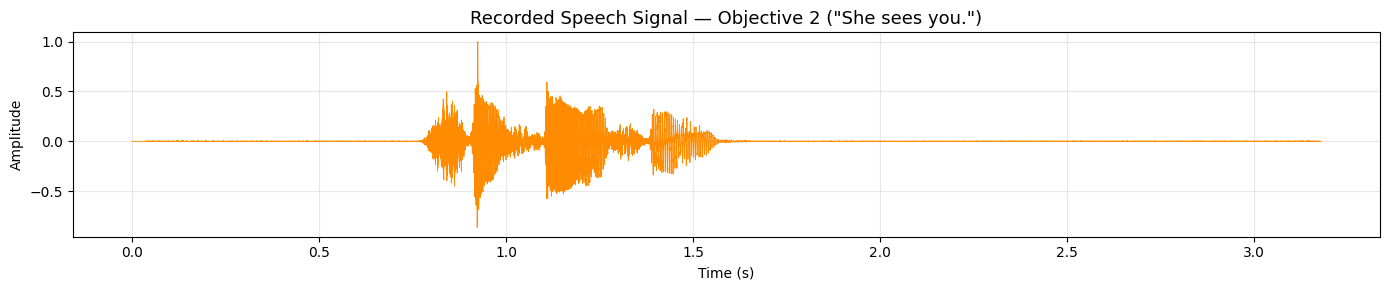

In [11]:
time_axis2 = np.arange(waveform2.shape[1]) / sample_rate2

plt.figure(figsize=(14, 3))
plt.plot(time_axis2, waveform2[0].numpy(), color='darkorange', linewidth=0.6)
plt.title('Recorded Speech Signal — Objective 2 ("She sees you.")', fontsize=13)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Phoneme Recognition — "She sees you."

In [12]:
input_values2 = processor(
    waveform_np2,
    sampling_rate=TARGET_SR,
    return_tensors="pt"
).input_values

with torch.no_grad():
    logits2 = model(input_values2).logits

predicted_ids2 = torch.argmax(logits2, dim=-1)
transcription2 = processor.decode(predicted_ids2[0])

print("Recognized Character Sequence:")
print(transcription2)

Recognized Character Sequence:
SHE SEES YOU


## 14. Segment Phonemes — Objective 2

In [13]:
# Reuse the same segmentation function from Objective 1
phoneme_intervals2 = get_phoneme_intervals(
    predicted_ids2, logits2, waveform2, sample_rate2, processor
)

# Assign categories
for p in phoneme_intervals2:
    p["category"] = phoneme_categories.get(p["phoneme"].upper(), "whisper/other")

print(f"Detected {len(phoneme_intervals2)} phoneme segments:")
for p in phoneme_intervals2:
    print(f"  {p['phoneme']:>4s}  →  {p['category']:15s}  "
          f"{p['start_sample']/sample_rate2:.3f}s – "
          f"{p['end_sample']/sample_rate2:.3f}s")

Detected 9 phoneme segments:
     S  →  fricative        0.845s – 0.865s
     H  →  fricative        0.865s – 0.905s
     E  →  vowel            0.905s – 1.066s
     S  →  fricative        1.066s – 1.127s
     E  →  vowel            1.127s – 1.267s
     S  →  fricative        1.267s – 1.388s
     Y  →  semivowel        1.388s – 1.448s
     O  →  vowel            1.448s – 1.469s
     U  →  vowel            1.469s – 3.179s


## 15. Identify and Plot Fricatives and Approximants

For the sentence *"She sees you"*, we expect:
- **Fricatives**: /ʃ/ → `S` or `H`, /s/ → `S`, /z/ → `Z`
- **Approximant**: /j/ → `Y`

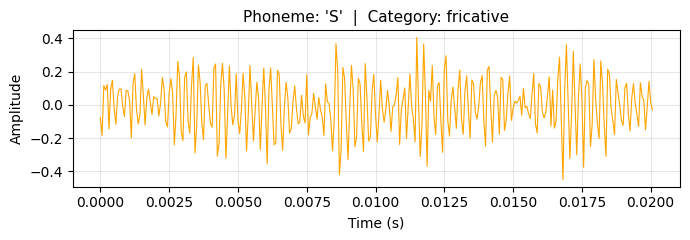

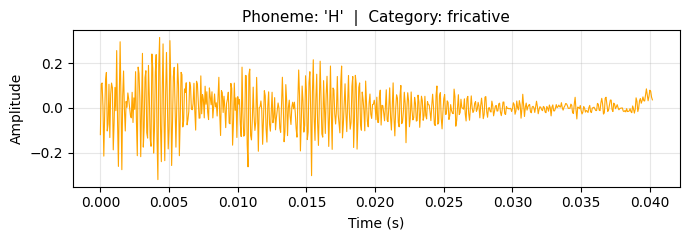

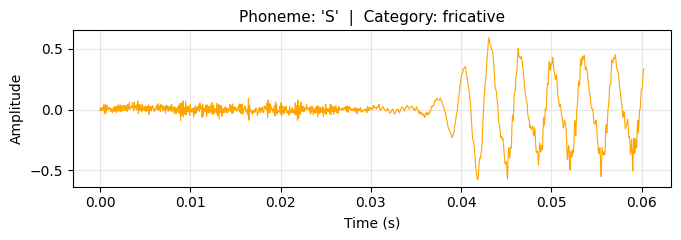

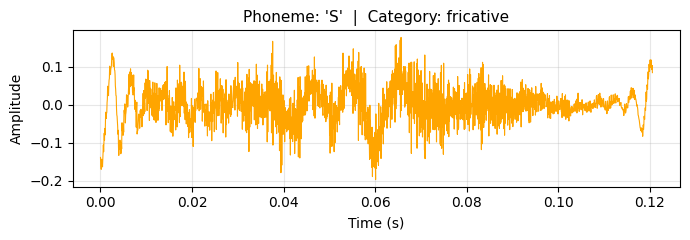

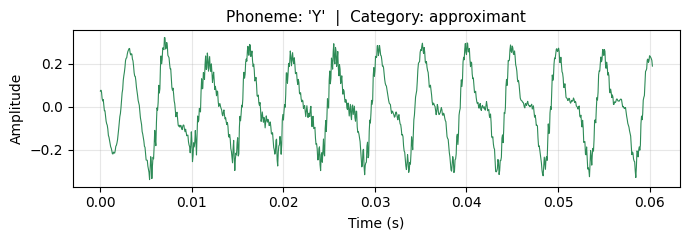

In [14]:
fricative_segments   = []
approximant_segments = []

for p in phoneme_intervals2:
    cat = p["category"]
    dur = p["end_sample"] - p["start_sample"]
    if dur == 0:
        continue
    seg = waveform2[0, p["start_sample"]:p["end_sample"]].numpy()

    if cat == "fricative":
        fricative_segments.append((p["phoneme"], seg))
        plot_phoneme(seg, sample_rate2, p["phoneme"], "fricative", color='orange')

    elif cat == "semivowel":   # approximants are classified as semivowels
        approximant_segments.append((p["phoneme"], seg))
        plot_phoneme(seg, sample_rate2, p["phoneme"], "approximant", color='seagreen')

if not fricative_segments:
    print("No fricative segments found. Check transcription above.")
if not approximant_segments:
    print("No approximant segments found. Check transcription above.")

## 16. Side-by-Side Comparison — Fricative vs Approximant

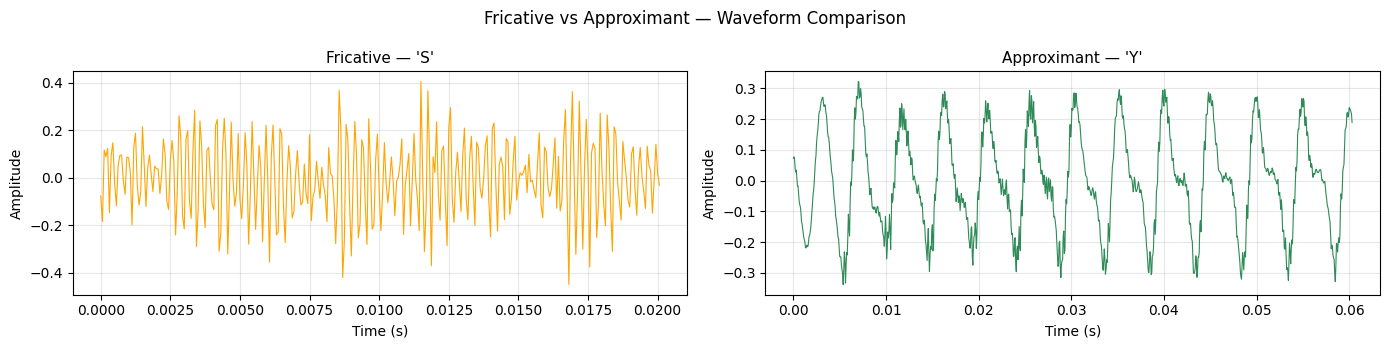

In [15]:
if fricative_segments and approximant_segments:
    fric_name, fric_seg = fricative_segments[0]
    appr_name, appr_seg = approximant_segments[0]

    fig, axes = plt.subplots(1, 2, figsize=(14, 3.5))

    tf = np.arange(len(fric_seg)) / sample_rate2
    axes[0].plot(tf, fric_seg, color='orange', linewidth=0.8)
    axes[0].set_title(f"Fricative — '{fric_name}'", fontsize=11)
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(alpha=0.3)

    ta = np.arange(len(appr_seg)) / sample_rate2
    axes[1].plot(ta, appr_seg, color='seagreen', linewidth=0.8)
    axes[1].set_title(f"Approximant — '{appr_name}'", fontsize=11)
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude")
    axes[1].grid(alpha=0.3)

    plt.suptitle("Fricative vs Approximant — Waveform Comparison", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot comparison: one or both segment types not detected.")
    print("All detected segments:")
    for p in phoneme_intervals2:
        print(f"  {p['phoneme']}  →  {p['category']}")

## 17. Analysis — Fricatives vs Approximants: Turbulence and Airflow

### Waveform Observations

| Feature | Fricatives (/s/, /ʃ/, /z/) | Approximants (/j/) |
|---|---|---|
| **Waveform smoothness** | Highly irregular, jagged, noise-like | Relatively smooth and continuous |
| **Amplitude continuity** | Rapidly fluctuating with no stable envelope | Gradual, consistent amplitude changes |
| **Noise-like fluctuations** | Strongly present — broadband random energy | Largely absent — waveform resembles a vowel |
| **Periodicity** | Aperiodic | Semi-periodic (voice-bar visible) |
| **Energy variation** | High, rapid variation | Low, slow variation |

### Airflow Turbulence Inference

**Fricatives — Turbulent airflow (high effective Reynolds number):**  
Fricatives are produced by forcing a high-velocity airstream through a very narrow constriction (e.g., the tongue-tip near the alveolar ridge for /s/, or the blade of the tongue near the palate for /ʃ/). At such narrow constrictions, the local flow velocity rises sharply, exceeding the critical Reynolds number threshold and causing the airflow to transition from laminar to **turbulent**. This turbulence generates wideband, aperiodic pressure fluctuations — visually apparent as the noisy, irregular waveform observed for fricatives.

**Approximants — Laminar/smooth airflow (low effective Reynolds number):**  
Approximants (e.g., /j/ as in *you*) are produced with a wide, open constriction. The airstream passes through with relatively low velocity, remaining below the critical Reynolds number, so the flow stays **laminar**. The resulting waveform is smooth, quasi-periodic (voiced), and closely resembles that of a vowel — reflecting the near-absence of turbulent pressure fluctuations.

### Articulatory Constriction Differences

The key difference lies in the **degree of articulatory constriction**:
- **Fricatives** have a **narrow constriction** → high local air velocity → turbulent flow → noisy waveform.
- **Approximants** have a **wide constriction** → low local air velocity → laminar flow → smooth waveform.

This directly parallels fluid dynamics: a smaller channel cross-section (at fixed volumetric flow rate) produces higher velocity and higher Reynolds number, driving the transition from laminar to turbulent flow.